In [42]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

import jax
import jax.numpy as jnp
from jax import random, lax, vmap
from jax import jit

In [43]:
#generating random spin configuration
def initialize_spins(key, L):
    spins = random.choice(key, jnp.array([-1, 1]), shape=(L, L))  #randomly choosing between -1 and 1
    return spins

In [44]:
@jit  #hamiltonian function
def hamiltonian(spins, theta):
    L = spins.shape[0]
    H = -theta * jnp.sum(spins * (jnp.roll(spins, 1, axis=-2) + jnp.roll(spins, 1, axis=-2)), axis=(-2, -1))
    return H

In [45]:
@jit
def proposal(key, L):
    return random.randint(key, (2,), 0, L) #randomly choosing which bit to flip

ANALYTICAL GRADIENT CALCULATIONS

In [46]:
@jit  #single Metropolis-Hastings step
def step_analytical(state, _):
    spins, beta, key, theta = state
    L = spins.shape[0]
    i, j = proposal(key, L)  #proposing  which bit to flip
    
    #change in energy
    delta_E = 2 * theta * spins[i, j] * (spins[i, (j+1) % L] + spins[i, (j-1) % L] + spins[(i+1) % L, j] + spins[(i-1) % L, j])
    
    key, subkey = random.split(key)
    accept = (delta_E < 0) | (random.uniform(subkey) < jnp.exp(-beta * delta_E))
    spins = spins.at[i, j].set(lax.select(accept, -spins[i, j], spins[i, j]))
    return (spins, beta, key, theta), accept


In [47]:
#single temperature MCMC process
def single_temperature_mcmc_analytical_warm_start(L, iterations, T, step_recording, theta, thermalization, key, initial_spins):
    beta = 1.0 / T
    spins = initial_spins
    state = (spins, beta, key, theta)
    
    # Thermalization
    state, accepts = lax.scan(step_analytical, state, None, length=thermalization)
    
    num_samples = (iterations - thermalization) // step_recording
    all_samples = jnp.zeros((num_samples, L, L))
    energies = []

    # Sampling with step recording
    @jit
    def sampling_update(state, step_idx):
        state, _ = lax.scan(step_analytical, state, None, length=step_recording)
        all_samples = state[0]
        energy = hamiltonian(state[0], theta)
        energies.append(energy)
        return state, (all_samples, energy)
    
    state, results = lax.scan(sampling_update, state, jnp.arange(num_samples))
    all_samples, energies = results
    
    avg_energy = jnp.mean(energies)
    avg_energy_squared = jnp.mean(energies**2)
    final_spins = state[0]
    
    return avg_energy, avg_energy_squared, all_samples, key, jnp.array(energies), final_spins



In [48]:
#energy
def O(x, theta):
        return hamiltonian(x, theta)
    
#energy squared
def O_squared(x, theta):
        return (hamiltonian(x, theta))**2

In [49]:
#energy gradient w.r.t temperature dE/dT
def compute_energy_gradient(T, samples, theta, O):

    #model
    def log_p(T, x):
            return -1/T * hamiltonian(x, theta)

    N = len(samples)
    O_values = O(samples, theta)
    ō = jnp.mean(O_values)
    ΔO = O_values - ō
    gradient = jax.vjp(log_p, T, samples)[1](ΔO/ N) 

    return ō, gradient[0]

In [50]:
#heat capacity gradient w.r.t temperature dC/dT
def compute_heat_capacity_gradient(T, samples, theta):

    e, grad_e = compute_energy_gradient(T, samples, theta, O)
    e2, grad_e2 = compute_energy_gradient(T, samples, theta, O_squared)

    heat_capacity = (e2 - e**2)/(T**2)

    term1 = -2./T * heat_capacity
    term2 = 1/(T**2) * (grad_e2 -2 * e * grad_e)
    dC = term1 +  term2

    return dC, heat_capacity

In [51]:

#this one makes a perfect mcmc graph + good T_c vs L graph
# key = random.PRNGKey(0)
# L = 12  #grid size
# iterations = 150000
# thermalization = int(0.25 * iterations)
# step_recording = 20 #maybe L**2
# temperature_range = jnp.linspace(0.1, 10.0, 50)
# theta = 1.0
# k_B = 1.0
# T_c = 2 * theta / (k_B * jnp.log(1 + jnp.sqrt(2)))

key = random.PRNGKey(0)
L = 12  #grid size
iterations = 120000
thermalization = int(0.25 * iterations)
step_recording = L**2 #maybe L**2
temperature_range = jnp.linspace(0.1, 10.0, 50)
theta = 1.0
k_B = 1.0
T_c = 2 * theta / (k_B * jnp.log(1 + jnp.sqrt(2)))

In [52]:
# ------------------------ PERFORMING MCMC
all_energies = jnp.zeros(len(temperature_range))
all_energies_squared = jnp.zeros(len(temperature_range))
all_samples_list = []
initial_spins = initialize_spins(key, L)

key = random.PRNGKey(0)

for idx, T in enumerate(temperature_range):
    key, subkey = random.split(key)
    avg_energy, avg_energy_squared, samples, key, energies, final_spins = single_temperature_mcmc_analytical_warm_start(L, iterations, T, step_recording, theta, thermalization, subkey, initial_spins)
    initial_spins = final_spins
    all_energies = all_energies.at[idx].set(avg_energy)
    all_energies_squared = all_energies_squared.at[idx].set(avg_energy_squared)
    all_samples_list.append(samples)

all_samples = jnp.concatenate(all_samples_list, axis=0)  

average_energies = all_energies
average_energies_squared = all_energies_squared

heat_capacities = (average_energies_squared - average_energies**2) / (temperature_range**2)
heat_capacity_variance = (average_energies_squared - average_energies**2) / (temperature_range**4)

#for testing old and new mcmc
avg_energies_old = average_energies
heap_capacities_old = heat_capacities

print(all_samples.shape)


(31250, 12, 12)


In [53]:
#plotting
def plot_mcmc_results(temperature_range, average_energies, heat_capacities):
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    #plot Average Energy vs Temperature
    axes[0].errorbar(temperature_range, average_energies, fmt='o', markersize=4)
    axes[0].axvline(x=T_c, color='red', linestyle='--')
    axes[0].set_xlabel('Temperature')
    axes[0].set_ylabel('Average Energy')
    axes[0].set_title('Average Energy vs Temperature')

    #plot Heat Capacity vs Temperature
    axes[1].errorbar(temperature_range, heat_capacities, fmt='o', markersize=4)
    axes[1].axvline(x=T_c, color='red', linestyle='--')
    axes[1].set_xlabel('Temperature')
    axes[1].set_ylabel('Heat Capacity')
    axes[1].set_title('Heat Capacity vs Temperature')

    plt.tight_layout()
    plt.show()

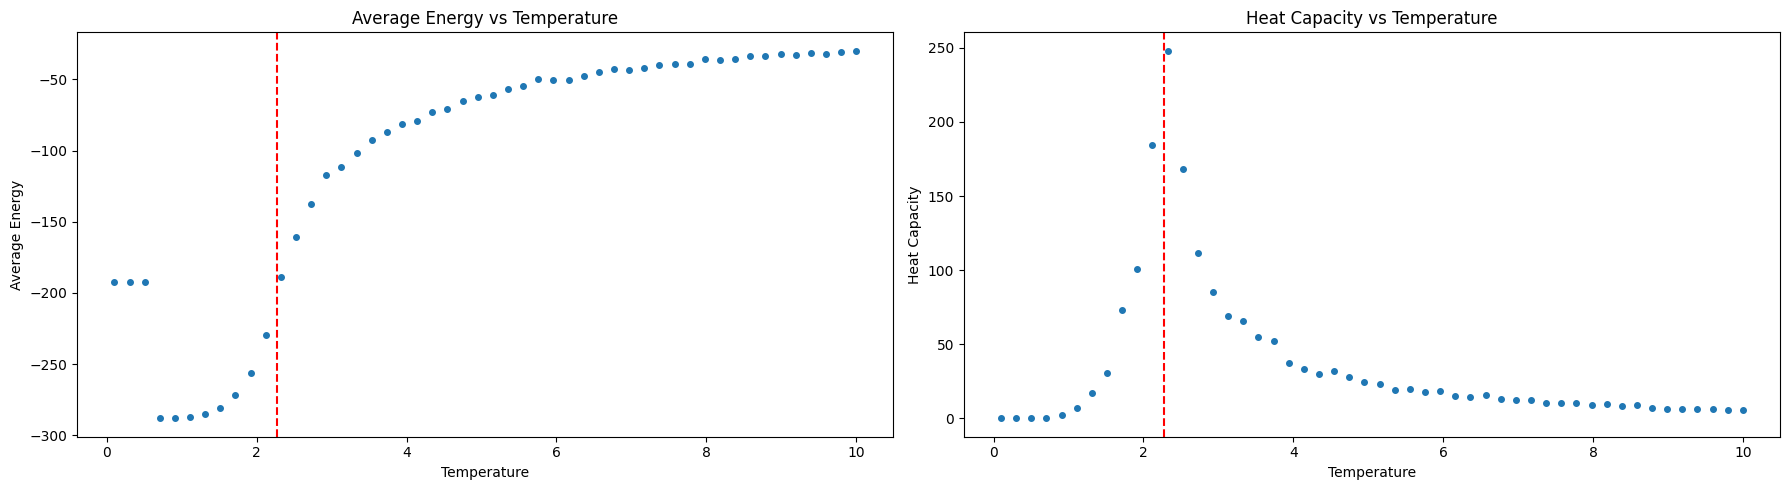

In [54]:
plot_mcmc_results(temperature_range, avg_energies_old, heap_capacities_old)

In [55]:
#capturing spin configurations at specific times
def capture_spin_configurations(L, iterations, temperature, theta, capture_times):
    key = random.PRNGKey(0)
    beta = 1.0 / temperature
    spins = initialize_spins(key, L)
    state = (spins, beta, key, theta)

    configurations = []
    current_iteration = 0
    for capture_time in capture_times:
        while current_iteration < capture_time:
            state, _ = lax.scan(step_analytical, state, None, length=capture_time - current_iteration)
            current_iteration = capture_time
        configurations.append(state[0])

    return configurations

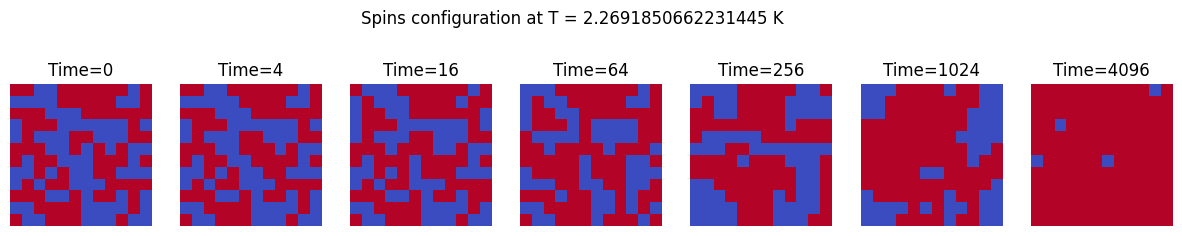

In [56]:
#------------------------ SPINS CONFIGURATION

temperature = T_c
capture_times = [0, 4, 16, 64, 256, 1024, 4096]
configurations = capture_spin_configurations(L, iterations, temperature, theta, capture_times)

#plotting spin configurations
fig, axes = plt.subplots(1, len(capture_times), figsize=(15, 3))
for ax, spins, time in zip(axes, configurations, capture_times):
    ax.imshow(spins, cmap='coolwarm')
    ax.set_title(f'Time={time}')
    ax.axis('off')
plt.suptitle(f'Spins configuration at T = {temperature} K')
plt.show()

In [57]:
# ------------------------ GRADIENTS (ANALYTICAL)

#at random temperature gradient_temperature
gradient_temperature = 2.567056894302368
L = 12 #set to a testing grid
initial_spins = initialize_spins(key, L)

key = jax.random.PRNGKey(0)
key, subkey = random.split(key)
avg_energy, avg_energy_squared, samples_2, key, energies, _ = single_temperature_mcmc_analytical_warm_start(L, iterations, gradient_temperature, step_recording, theta, thermalization, subkey, initial_spins)
heat_capacity_gradient, hc = compute_heat_capacity_gradient(gradient_temperature, samples_2, theta)
print(f"Heat capacity gradient at random temperature of value {gradient_temperature} is {heat_capacity_gradient}.")


#at critical temperature T_c
key = jax.random.PRNGKey(0)
key, subkey = random.split(key)
avg_energy, avg_energy_squared, samples_3, key, energies, _ = single_temperature_mcmc_analytical_warm_start(L, iterations, T_c, step_recording, theta, thermalization, subkey, initial_spins)
print("")
heat_capacity_gradient_critical, hc = compute_heat_capacity_gradient(T_c, samples_3, theta)
print(f"Heat capacity gradient at critical temperature of value {T_c} is {heat_capacity_gradient_critical}.")


Heat capacity gradient at random temperature of value 2.567056894302368 is -122.30841064453125.

Heat capacity gradient at critical temperature of value 2.2691850662231445 is -213.91822814941406.


In [58]:
#--------------------- GRADIENT ASCENT (ANALYTICAL)

def gradient_ascent_analytical_warm_start(learning_rate, initial_temperature, num_steps, L, iterations, step_recording, theta, thermalization):
    key = random.PRNGKey(0)
    T = initial_temperature

    temperatures = jnp.zeros(num_steps)
    heat_capacities = jnp.zeros(num_steps)
    
    #initialize spins for the first run
    spins = initialize_spins(key, L)

    @jit
    def body_fun(i, val):
        T, key, temps, hcs, spins = val
        key, subkey = random.split(key)

        _, _, samples_ascent, key, _, final_spins = single_temperature_mcmc_analytical_warm_start(L, iterations, T, step_recording, theta, thermalization, subkey, spins)
        
        heat_capacity_gradient, hc = compute_heat_capacity_gradient(T, samples_ascent, theta)

        new_temp = T + learning_rate * heat_capacity_gradient
        new_temp = jnp.clip(new_temp, 0.1, 10.0)  #stays within bounds

        temps = temps.at[i].set(new_temp)
        hcs = hcs.at[i].set(hc)

        return new_temp, key, temps, hcs, final_spins

    final_T, _, temperatures, heat_capacities, _ = jax.lax.fori_loop(0, num_steps, body_fun, (T, key, temperatures, heat_capacities, spins))
    return final_T, temperatures, heat_capacities


In [59]:
def perform_gradient_ascent(grad_asct_fun, num_steps, starting_temperature, learning_rate, L, iterations, step_recording, theta, thermalization, T_c):
                        
    optimized_temperature, all_temperatures, all_heat_capacities = grad_asct_fun(learning_rate, starting_temperature, num_steps, L, iterations, step_recording, theta, thermalization)

    #bootstrap resampling
    n_bootstrap = 50
    bootstrap_samples = np.random.choice(all_heat_capacities, (n_bootstrap, num_steps), replace=True) #n_bootstrap rows (bootstrap samples) and num_steps columns
    error_bars = np.std(bootstrap_samples, axis=0)

    print(f"Optimized temperature for maximum heat capacity is: {optimized_temperature}")
    print(f"Critical temperature is: {T_c}")
    print("")
    print(f"Difference between optimized and critical temperature is: {optimized_temperature - T_c}")

    return all_temperatures, all_heat_capacities, error_bars

In [60]:
def plot_gradient_ascent_results(all_temperatures, all_heat_capacities, T_c, error_bars):

    time_points = np.arange(len(all_heat_capacities))

    plt.figure(figsize=(10, 5))
    plt.fill_between(time_points[::10], (all_heat_capacities - error_bars)[::10], (all_heat_capacities + error_bars)[::10], color='red', alpha=0.4, label='Error')
    plt.plot(time_points[::10], all_heat_capacities[::10], label='Heat Capacity')  #plot every 10th point
    plt.xlabel('Time')
    plt.ylabel('Heat Capacity')
    plt.title('Heat Capacity vs Time (Gradient Ascent Process)')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(all_heat_capacities, markersize=3)
    plt.xlabel('Time')
    plt.ylabel('Heat Capacity')
    plt.title('Heat Capacity vs Time (Gradient Ascent Process)')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(all_temperatures, markersize=3)
    plt.axhline(y=T_c, color='red', linestyle='--', label='Critical Temperature')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.title('Optimised Temperature vs Time (Gradient Ascent Process)')
    plt.grid(True)
    plt.legend()
    plt.show()

In [61]:
num_steps = 1000
starting_temperature = 5.0
learning_rate = 0.0005
L = 12

all_temperatures, all_heat_capacities, error_bars = perform_gradient_ascent(gradient_ascent_analytical_warm_start, num_steps, starting_temperature, learning_rate, L, iterations, step_recording, theta, thermalization, T_c)

Optimized temperature for maximum heat capacity is: 2.3389251232147217
Critical temperature is: 2.2691850662231445

Difference between optimized and critical temperature is: 0.06974005699157715


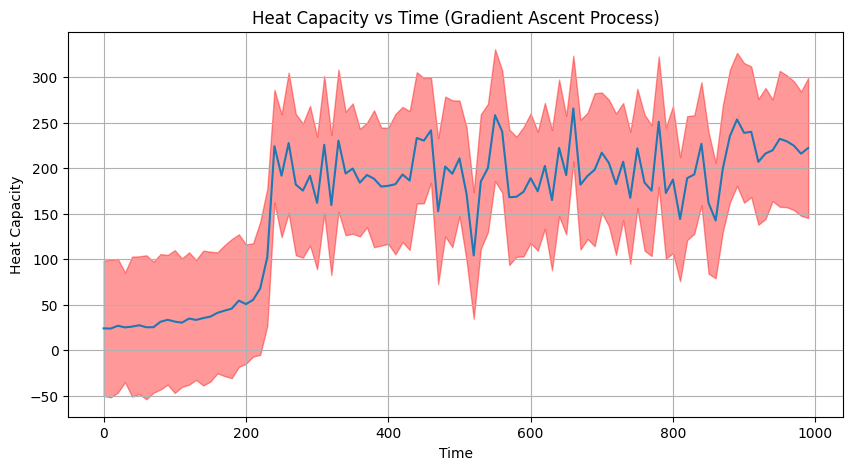

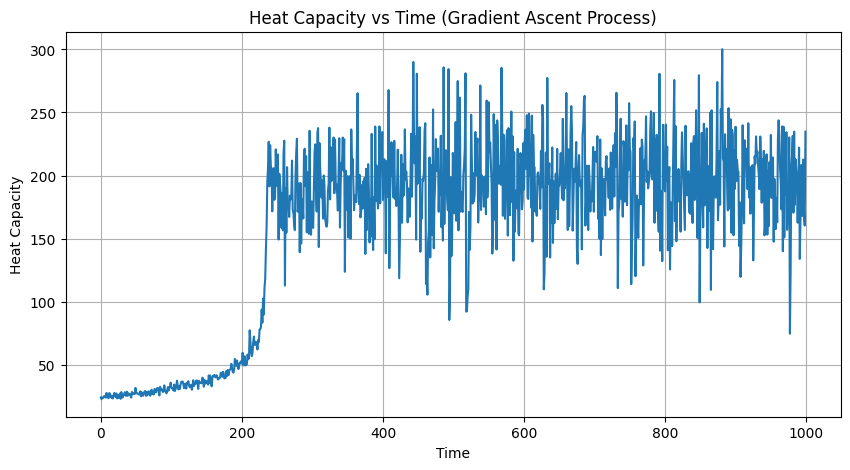

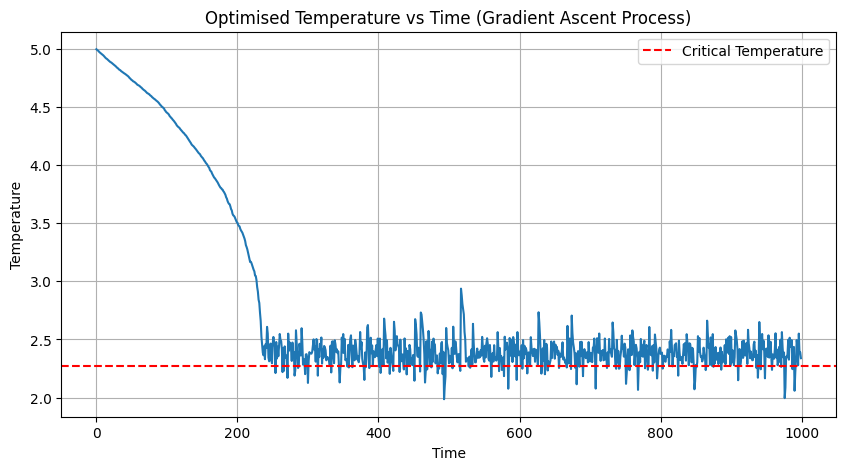

In [62]:
#plotting results
plot_gradient_ascent_results(all_temperatures, all_heat_capacities, T_c, error_bars)

In [72]:
#ADAM OPTIMIZER

import optax

def gradient_ascent_analytical_adam(learning_rate, initial_temperature, num_steps, L, iterations, step_recording, theta, thermalization):
    key = random.PRNGKey(0)
    T = initial_temperature

    temperatures = jnp.zeros(num_steps)
    heat_capacities = jnp.zeros(num_steps)
    
    spins = initialize_spins(key, L)

    adam_optimizer = optax.adam(learning_rate)
    opt_state = adam_optimizer.init(initial_temperature)

    @jit
    def body_fun(i, val):
        T, opt_state, key, temps, hcs, spins = val
        key, subkey = random.split(key)

        _, _, samples_ascent, key, _, final_spins = single_temperature_mcmc_analytical_warm_start(L, iterations, T, step_recording, theta, thermalization, subkey, spins)
        
        heat_capacity_gradient, hc = compute_heat_capacity_gradient(T, samples_ascent, theta)

        updates, opt_state = adam_optimizer.update(-heat_capacity_gradient, opt_state, T)
        new_temp = optax.apply_updates(T, updates)
        #new_temp = T + learning_rate * heat_capacity_gradient
        new_temp = jnp.clip(new_temp, 0.1, 10.0)  #stays within bounds

        temps = temps.at[i].set(new_temp)
        hcs = hcs.at[i].set(hc)

        return new_temp, opt_state, key, temps, hcs, final_spins

    final_T, opt_state, key, temperatures, heat_capacities, spins = jax.lax.fori_loop(0, num_steps, body_fun, (T, opt_state, key, temperatures, heat_capacities, spins))
    return final_T, temperatures, heat_capacities


In [84]:
num_steps = 500
starting_temperature = 5.0
learning_rate = 0.01
L = 12

all_temperatures_adam, all_heat_capacities_adam, error_bars_adam = perform_gradient_ascent(gradient_ascent_analytical_adam, num_steps, starting_temperature, learning_rate, L, iterations, step_recording, theta, thermalization, T_c)


Optimized temperature for maximum heat capacity is: 2.31323504447937
Critical temperature is: 2.2691850662231445

Difference between optimized and critical temperature is: 0.044049978256225586


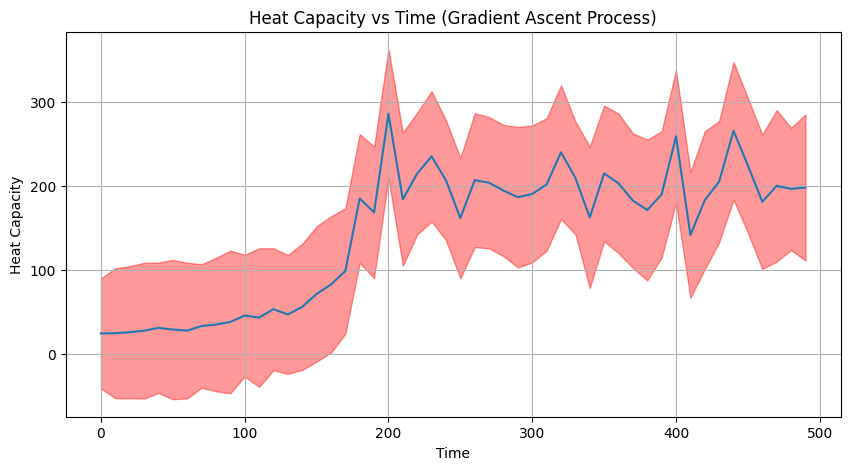

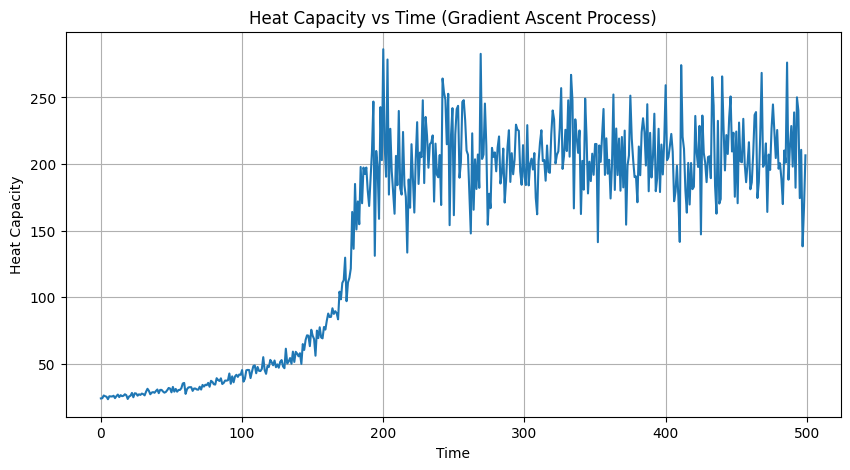

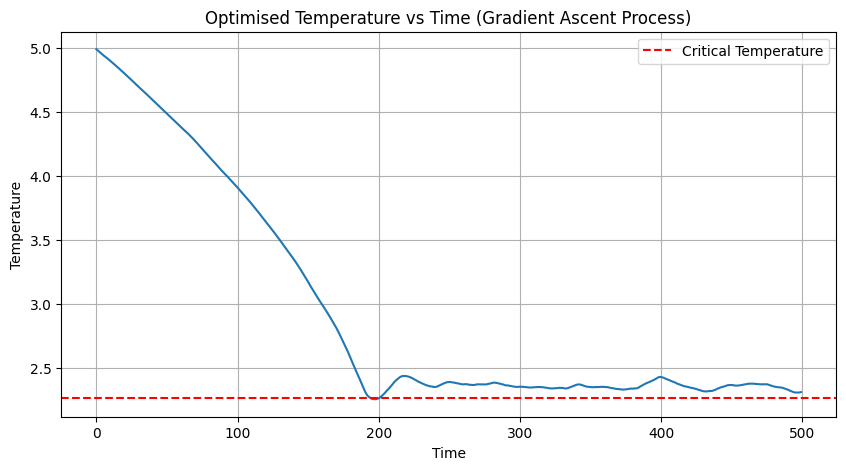

In [85]:
plot_gradient_ascent_results(all_temperatures_adam, all_heat_capacities_adam, T_c, error_bars_adam)

In [87]:
#T_c vs L graph

def calculate_converged_Tc(temperatures, num_last_iterations=50):
    return np.mean(temperatures[-num_last_iterations:])


def T_c_vs_L(perform_grad_fun, inner_grad_func, L_values, num_steps, initial_temperature, learning_rate, iterations, step_recording, theta, thermalization, T_c_star ):

    converged_Tc_values = []
    delta_Tc_values = []

    for L in L_values:

        print("")
        print(f"L = {L}:")

        step_recording = L**2
        
        temperatures, _, _ = perform_grad_fun(inner_grad_func, num_steps, initial_temperature, learning_rate, L, iterations, step_recording, theta, thermalization, T_c_star)
                                                                
        T_c_converged = calculate_converged_Tc(temperatures)
        converged_Tc_values.append(T_c_converged)
        
        delta_Tc = abs(T_c_converged - T_c_star)
        delta_Tc_values.append(delta_Tc)
    
    return converged_Tc_values, delta_Tc_values

                             


L = 1:
Optimized temperature for maximum heat capacity is: 2.2650134563446045
Critical temperature is: 2.2691850662231445

Difference between optimized and critical temperature is: -0.004171609878540039

L = 2:
Optimized temperature for maximum heat capacity is: 3.384122133255005
Critical temperature is: 2.2691850662231445

Difference between optimized and critical temperature is: 1.1149370670318604

L = 3:
Optimized temperature for maximum heat capacity is: 2.865885019302368
Critical temperature is: 2.2691850662231445

Difference between optimized and critical temperature is: 0.5966999530792236

L = 4:
Optimized temperature for maximum heat capacity is: 2.662531852722168
Critical temperature is: 2.2691850662231445

Difference between optimized and critical temperature is: 0.39334678649902344

L = 5:
Optimized temperature for maximum heat capacity is: 2.561387300491333
Critical temperature is: 2.2691850662231445

Difference between optimized and critical temperature is: 0.292202234268

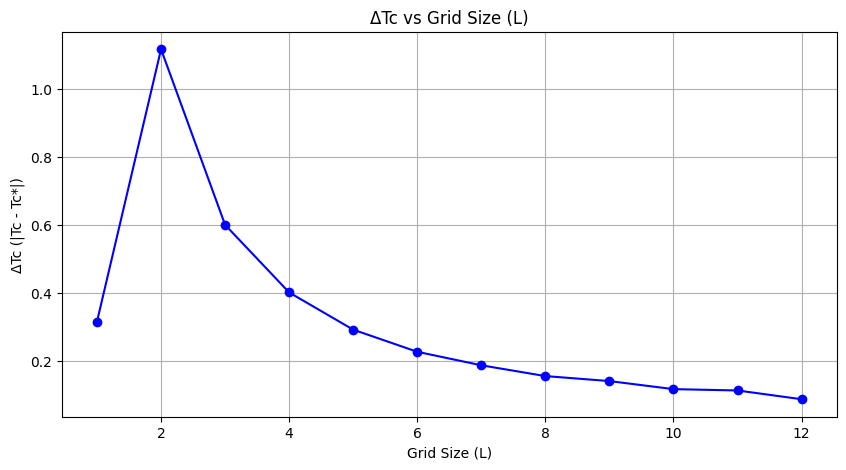

In [88]:
L_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] #add up to L = 12
initial_temperature = 5.0

converged_Tc_values, delta_Tc_values = T_c_vs_L(perform_gradient_ascent, gradient_ascent_analytical_adam, L_values, num_steps, initial_temperature, learning_rate, iterations, step_recording, theta, thermalization, T_c)

#plot delta_Tc vs L: finite system L->infinity
plt.figure(figsize=(10, 5))
plt.plot(L_values, delta_Tc_values, marker='o', linestyle='-', color='b')
plt.xlabel('Grid Size (L)')
plt.ylabel('ΔTc (|Tc - Tc*|)')
plt.title('ΔTc vs Grid Size (L)')
plt.grid(True)
plt.show()

DIFFERENTIATING METROPOLIS-HASTINGS ->
STOCHASTIC GRADIENT CALCULATIONS

In [89]:
@jit
def coupled_proposal(subkey, L):
    i, j = proposal(subkey, L)

    return(i,j), (i,j)

In [90]:
#logarithm of the unnormalized density function
def log_g_theta(spins, beta, theta):
    return -beta * hamiltonian(spins, theta)

@jit #Boltzmann distribution density fucntion
def g_theta(spins, beta, theta):
    return jnp.exp(log_g_theta(spins, beta, theta))

In [91]:
def delta_E(theta, spins, i, j):
        L = spins.shape[0]
        return 2 * theta * spins[i, j] * (spins[i, (j+1) % L] + spins[i, (j-1) % L] + spins[(i+1) % L, j] + spins[(i-1) % L, j])

In [92]:
def log_ratio(theta, spins, i, j, T): #log of the ratio of probabilities
    beta = 1. / T
    return -beta * delta_E(theta, spins, i, j)

@jit
def compute_alpha(log_ratio_prob_primal):
    return jnp.minimum(1.0, jnp.exp(log_ratio_prob_primal))

In [93]:
from functools import partial

In [94]:
def compute_derivative_alpha(alpha_primal, log_ratio_prob_primal_fn, beta):
    return alpha_primal * jax.grad(log_ratio_prob_primal_fn)(1/beta)

In [95]:
#T-samples differentiable Metropolis-Hastings step
@jit
def step_stochastic(state, _):
    spins_primal, spins_coupled, beta, theta, gradient, gradient_squared, key, w_i = state
    L = spins_primal.shape[0]
    
    key, subkey = random.split(key)
    U = random.uniform(subkey)
    (i, j), (i_coupled, j_coupled) = coupled_proposal(subkey, L)  #coupled proposal for both chains


    #primal chain
    log_ratio_prob_primal_fn = partial(log_ratio, theta, spins_primal, i, j)
    alpha_primal = compute_alpha(log_ratio_prob_primal_fn(1./beta))
    accept_primal = U <= alpha_primal
    
    new_spins_primal = spins_primal.at[i, j].set(-spins_primal[i, j]) #neg. sign for flipping it
    spins_primal_next = lax.select(accept_primal, new_spins_primal, spins_primal)  #pseudo-code line: if bx = 1 then xi+1 := x' else xi+1 := xi endif
    
    #coupled chain
    log_ratio_prob_coupled = log_ratio(theta, spins_coupled, i_coupled, j_coupled, 1/beta)
    alpha_coupled = compute_alpha(log_ratio_prob_coupled)
    accept_coupled = U <= alpha_coupled
    
    new_spins_coupled = spins_coupled.at[i_coupled, j_coupled].set(-spins_coupled[i_coupled, j_coupled]) #neg. sign for flipping it
    spins_coupled_next = lax.select(accept_coupled, new_spins_coupled, spins_coupled)  #pseudo-code line: if by = 1 then yi+1 := y' else yi+1 := yi endif

    derivative_alpha = compute_derivative_alpha(alpha_primal, log_ratio_prob_primal_fn, beta)

    @jit
    def compute_w():
        return (1 / alpha_primal) * jnp.maximum(0, -derivative_alpha)
    
    @jit
    def compute_w_not():
        return (1 / (1 - alpha_primal)) * jnp.maximum(0, derivative_alpha)
    
    w = lax.cond(accept_primal, compute_w, compute_w_not)  #pseudo-code lines: if bx = 1 then ... else ... endif
    
    #pruning step
    same_spins = (spins_primal_next == spins_coupled_next).all()

    w_i = lax.select(same_spins, 0.0, w_i)  #pseudo-code line: if yi+1 = xi+1 then wi := 0 end if
    w_i1 = w + w_i
    
    w̃ = random.uniform(subkey)

    spins_coupled_next = lax.select(
        w̃ * w_i1 < w, 
        lax.select(accept_primal, spins_primal, new_spins_primal),  #pseudo-code lines: if w̃ · wi+1 < w then if bx = 1 then yi+1 := xi else yi+1 := x' endif end if
        spins_coupled_next
    )
    
    #update gradient estimate
    gradient = gradient + w_i1 * (hamiltonian(spins_coupled_next, theta) - hamiltonian(spins_primal_next, theta)) #energy gradient ADD THE ADDITIONAL PART
    gradient_squared = gradient_squared + w_i1 * (O_squared(spins_coupled_next, theta) - O_squared(spins_primal_next, theta)) #energy squared gradient

    key, subkey = random.split(key)

    state = (spins_primal_next, spins_coupled_next, beta, theta, gradient, gradient_squared, key, w_i1)
    return state, gradient

In [96]:
def single_temperature_mcmc_stochastic_warm_start(L, iterations, T, step_recording, theta, thermalization, key, initial_spins):
    beta = 1.0 / T
    spins_primal = initial_spins
    spins_coupled = initialize_spins(key, L)
    gradient = 0.0
    gradient_squared = 0.0
    w_i = 0.0
    state = (spins_primal, spins_coupled, beta, theta, gradient, gradient_squared, key, w_i)
    
    # Thermalization
    state, _ = lax.scan(step_stochastic, state, None, length=thermalization)
    
    num_samples = (iterations - thermalization) // step_recording
    all_samples_primal = jnp.zeros((num_samples, L, L))
    all_samples_coupled = jnp.zeros((num_samples, L, L))
    energies = []
    energy_squares = []
    gradients = []

    @jit
    def sampling_update(state, step_idx, all_samples_primal, all_samples_coupled, energies, energy_squares, gradients):
        # Recording every 20th step
        state, _ = lax.scan(step_stochastic, state, None, length=step_recording)

        spins_primal, spins_coupled, beta, theta, gradient, gradient_squared, key, w_i = state
        energy_primal = hamiltonian(spins_primal, theta)
        
        all_samples_primal = all_samples_primal.at[step_idx].set(spins_primal)
        all_samples_coupled = all_samples_coupled.at[step_idx].set(spins_coupled)

        energies.append(energy_primal)
        energy_squares.append(energy_primal ** 2)
        gradients.append(gradient)
        
        return (spins_primal, spins_coupled, beta, theta, gradient, gradient_squared, key, w_i), (all_samples_primal, all_samples_coupled, energies, energy_squares, gradients)

    state, samples = lax.scan(
        lambda state, step_idx: sampling_update(state, step_idx, all_samples_primal, all_samples_coupled, energies, energy_squares, gradients),
        state,
        jnp.arange(num_samples)
    )

    all_samples_primal, all_samples_coupled, energies, energy_squares, all_gradients = samples

    avg_energy_primal = jnp.mean(jnp.array(energies))
    avg_energy_squared_primal = jnp.mean(jnp.array(energy_squares))
    hc = (avg_energy_squared_primal - avg_energy_primal**2) / T**2

    _, _, _, _, final_energy_gradient, final_energy_squared_gradient, _, _ = state

    # d/dT(E(T))
    mean_energy_gradient = final_energy_gradient / iterations

    # d/dT(E^2(T))
    mean_energy_squared_gradient = final_energy_squared_gradient / iterations

    # d/dT(C(T))
    A = (mean_energy_squared_gradient - 2 * avg_energy_primal * mean_energy_gradient) / T**2
    B = 2 * (avg_energy_squared_primal - avg_energy_primal**2) / T**3
    heat_capacity_gradient = A - B

    # Return final spins for warm start
    final_spins_primal = state[0]

    return (all_samples_primal, all_samples_coupled, avg_energy_primal, avg_energy_squared_primal, hc), mean_energy_gradient, mean_energy_squared_gradient, heat_capacity_gradient, final_spins_primal



In [126]:
#example
key = random.PRNGKey(0)
L = 4  #grid size --> grid for debugging the same as 
iterations = 10000
thermalization = int(0.25 * iterations)
step_recording = L**2
temperature_range = jnp.linspace(0.1, 10.0, 50)
theta = 1.0
k_B = 1.0
T_c = 2 * theta / (k_B * jnp.log(1 + jnp.sqrt(2)))
T_test = T_c

# key = random.PRNGKey(0)
# L = 4  #grid size
# iterations = 120000
# thermalization = int(0.25 * iterations)
# step_recording = L**2 #maybe L**2
# temperature_range = jnp.linspace(0.1, 10.0, 50)
# theta = 1.0
# k_B = 1.0
# T_c = 2 * theta / (k_B * jnp.log(1 + jnp.sqrt(2)))
# T_test = T_c

In [127]:
initial_spins = initialize_spins(key, L)
samples, energy_gradient, energy_squared_gradient, heat_capacity_gradient, _ = single_temperature_mcmc_stochastic_warm_start(L, iterations, T_test, step_recording, theta, thermalization, key, initial_spins)

all_samples_primal, all_samples_coupled, avg_energy_primal, avg_energy_squared_primal, heat_capacity = samples

print(f"Gradient of heat capacity at temperature {T_test}:", heat_capacity_gradient)
print(f"Heat capacity at temperature {T_test}:", heat_capacity)
print("")
print(f"Gradient of energy at temperature {T_test}:", energy_gradient)
print(f"Gradient of energy squared at temperature {T_test}:", energy_squared_gradient)
print("")
print(f"Energy at temperature {T_test}:", avg_energy_primal)


Gradient of heat capacity at temperature 2.2691850662231445: 5.942685
Heat capacity at temperature 2.2691850662231445: 12.727378

Gradient of energy at temperature 2.2691850662231445: 7.4577518
Gradient of energy squared at temperature 2.2691850662231445: -300.20636

Energy at temperature 2.2691850662231445: -26.051283


In [128]:
#running new MCMC
all_energies = jnp.zeros(len(temperature_range))
all_energies_squared = jnp.zeros(len(temperature_range))
all_primal_samples_list = []
all_coupled_samples_list = []
all_gradients_list = []

key = random.PRNGKey(0)
initial_spins = initialize_spins(key, L)

for idx, T in enumerate(temperature_range):
    key, subkey = random.split(key)
    (all_samples_primal, all_samples_coupled, avg_energy, avg_energy_squared, hc), mean_gradient, _, heat_capacity_gradient, final_spins_primal = single_temperature_mcmc_stochastic_warm_start(
        L, iterations, T, step_recording, theta, thermalization, subkey, initial_spins
    )
    
    # Update the initial spins for the next temperature
    initial_spins = final_spins_primal

    all_energies = all_energies.at[idx].set(avg_energy)
    all_energies_squared = all_energies_squared.at[idx].set(avg_energy_squared)

    all_primal_samples_list.append(all_samples_primal)
    all_coupled_samples_list.append(all_samples_coupled)
    all_gradients_list.append(mean_gradient) 

all_primal_samples_list = jnp.concatenate(all_primal_samples_list, axis=0)
all_coupled_samples_list = jnp.concatenate(all_coupled_samples_list, axis=0)
all_gradients = jnp.array(all_gradients_list)

heat_capacities = (all_energies_squared - all_energies**2) / (temperature_range**2)
heat_capacity_variance = (all_energies_squared - all_energies**2) / (temperature_range**4)

# For testing new and old
avg_energies_new = all_energies
heat_capacities_new = heat_capacities

STOCHASTIC MCMC SAMPLING:


Text(0.5, 1.0, 'Heat Capacity vs Temperature (at L = 4)')

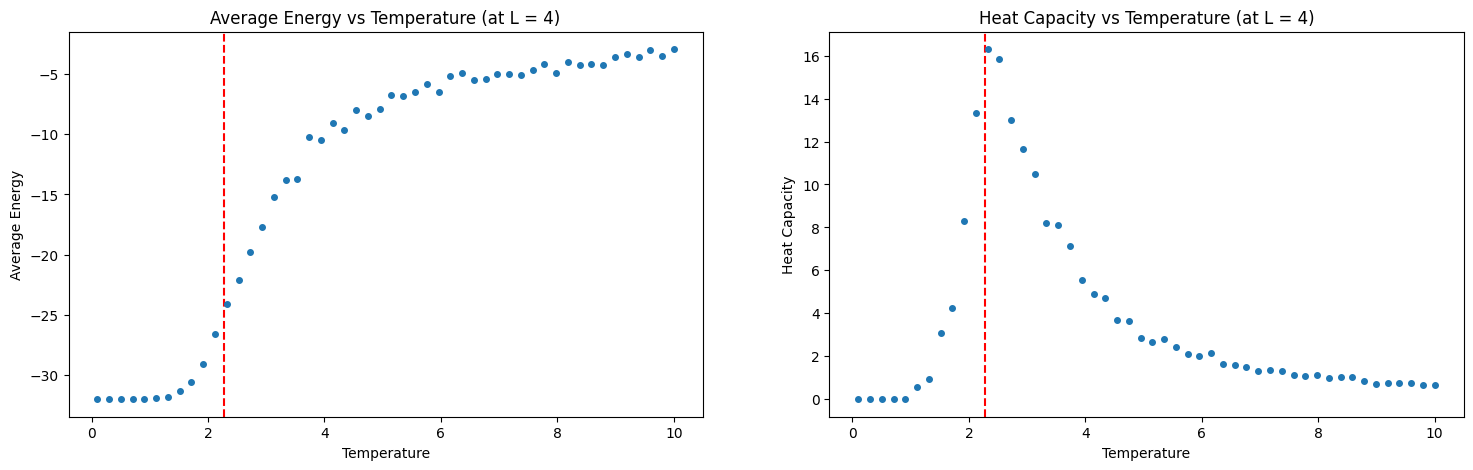

In [129]:
#plot_mcmc_results(temperature_range, avg_energies_new, heat_capacities_new)
print("STOCHASTIC MCMC SAMPLING:")

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
#plot Average Energy vs Temperature
axes[0].errorbar(temperature_range, avg_energies_new, fmt='o', markersize=4)
axes[0].axvline(x=T_c, color='red', linestyle='--')
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('Average Energy')
axes[0].set_title(f'Average Energy vs Temperature (at L = {L})')

#plot Heat Capacity vs Temperature
axes[1].errorbar(temperature_range, heat_capacities_new, fmt='o', markersize=4)
axes[1].axvline(x=T_c, color='red', linestyle='--')
axes[1].set_xlabel('Temperature')
axes[1].set_ylabel('Heat Capacity')
axes[1].set_title(f'Heat Capacity vs Temperature (at L = {L})')

In [30]:
i = (temperature_range > 2) * (temperature_range < 2.5)
x = temperature_range[i]
y = avg_energies_new[i]
np.polyfit(x, y, 1)

array([ 12.2679707 , -52.61139533])

In [28]:
y

Array([-26.598291, -24.11966 ], dtype=float32)

In [31]:
def gradient_ascent_stochastic_warm_start(learning_rate, initial_temperature, num_steps, L, iterations, step_recording, theta, thermalization):
    key = random.PRNGKey(0)
    T = initial_temperature

    temperatures = jnp.zeros(num_steps)
    heat_capacities = jnp.zeros(num_steps)

    # Initialize spins for the first run
    spins_primal = initialize_spins(key, L)

    @jit
    def body_fun(i, val):
        T, key, temps, hcs, spins_primal = val  # Modified: Added spins to state
        key, subkey = random.split(key)

        # Modified: Passing spins to MCMC and getting final spins
        samples, _, _, heat_capacity_gradient, final_spins_primal = single_temperature_mcmc_stochastic_warm_start(
            L, iterations, T, step_recording, theta, thermalization, subkey, spins_primal
        )
        _, _, _, _, hc = samples

        new_temp = T + learning_rate * heat_capacity_gradient
        new_temp = jnp.clip(new_temp, 0.1, 10.0)

        temps = temps.at[i].set(new_temp)
        hcs = hcs.at[i].set(hc)

        #(updating spins with final spins)
        return new_temp, key, temps, hcs, final_spins_primal

    #(added spins to initial state)
    final_T, _, temperatures, heat_capacities, _ = jax.lax.fori_loop(0, num_steps, body_fun, (T, key, temperatures, heat_capacities, spins_primal))
    
    return final_T, temperatures, heat_capacities

In [47]:
#example
learning_rate_stochastic = 0.001
initial_temperature = 5
num_steps_stochastic = 10000
L = 2 

temperatures, heat_capacities, error_bars = perform_gradient_ascent(gradient_ascent_stochastic_warm_start, num_steps, initial_temperature, learning_rate, L, iterations, step_recording, theta, thermalization, T_c)

print(f"Final optimized temperature for heat capactiy: {temperatures[-1]}")
print(f"Final optimized heat capacity: {heat_capacities[-1]}")
#print(f"Temperature progression: {temperatures}")
#print(f"Heat capacity progression: {heat_capacities}")

Optimized temperature for maximum heat capacity is: 2.663328170776367
Critical temperature is: 2.2691850662231445

Difference between optimized and critical temperature is: 0.39414310455322266
Final optimized temperature for heat capactiy: 2.663328170776367
Final optimized heat capacity: 2.1214005947113037


In [48]:
print(f"last 50 is: {np.mean(temperatures[-50:])}")
print(f"last 20 is: {np.mean(temperatures[-20:])}")
print(f"last 10 is: {np.mean(temperatures[-10:])}")

last 50 is: 2.6603236198425293
last 20 is: 2.6676793098449707
last 10 is: 2.668550968170166


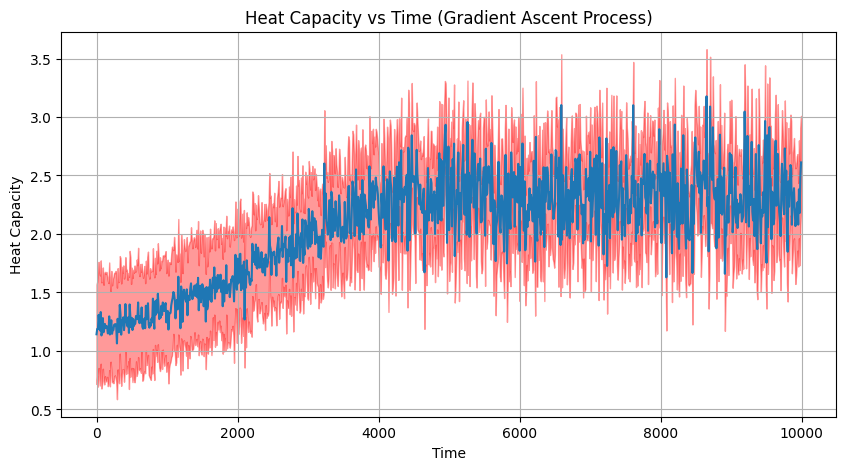

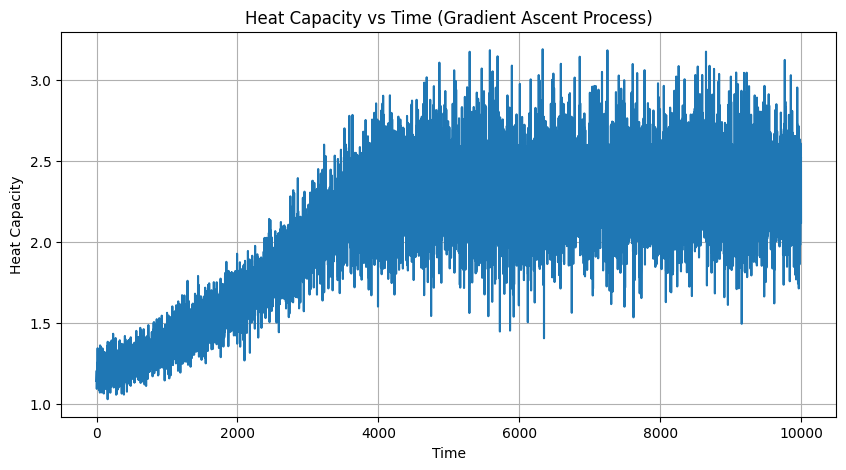

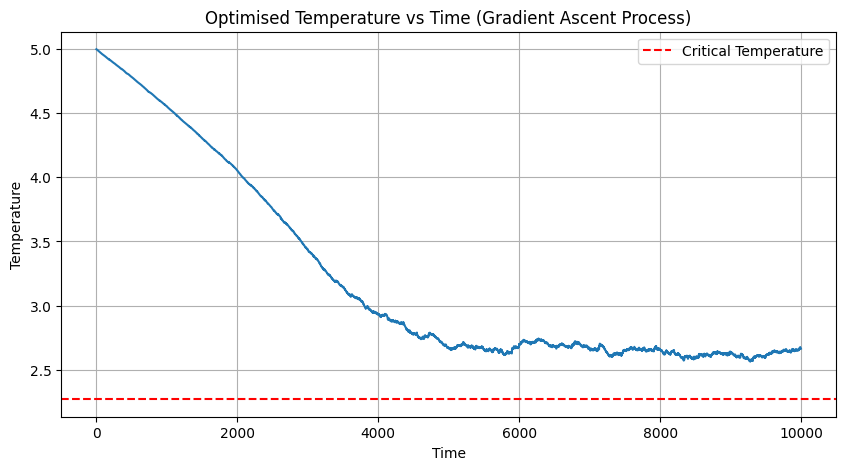

In [49]:
#plotting results
plot_gradient_ascent_results(temperatures, heat_capacities, T_c, error_bars)

In [99]:
#with adam optimizer

def gradient_ascent_stochastic_adam(learning_rate, initial_temperature, num_steps, L, iterations, step_recording, theta, thermalization):
    key = random.PRNGKey(0)
    T = initial_temperature

    temperatures = jnp.zeros(num_steps)
    heat_capacities = jnp.zeros(num_steps)
    
    spins = initialize_spins(key, L)

    adam_optimizer = optax.adam(learning_rate)
    opt_state = adam_optimizer.init(initial_temperature)

    @jit
    def body_fun(i, val):
        T, opt_state, key, temps, hcs, spins = val
        key, subkey = random.split(key)

        samples, _, _, heat_capacity_gradient, final_spins = single_temperature_mcmc_stochastic_warm_start(L, iterations, T, step_recording, theta, thermalization, subkey, spins)

        _, _, _, _, hc = samples
        updates, opt_state = adam_optimizer.update(-heat_capacity_gradient, opt_state, T)
        new_temp = optax.apply_updates(T, updates)
        new_temp = jnp.clip(new_temp, 0.1, 10.0)  #stays within bounds

        temps = temps.at[i].set(new_temp)
        hcs = hcs.at[i].set(hc)

        return new_temp, opt_state, key, temps, hcs, final_spins

    final_T, opt_state, key, temperatures, heat_capacities, spins = jax.lax.fori_loop(0, num_steps, body_fun, (T, opt_state, key, temperatures, heat_capacities, spins))
    return final_T, temperatures, heat_capacities


In [109]:
learning_rate_stochastic = 0.01 
initial_temperature = 5
num_steps_stochastic = 2000
L = 2 

temperatures_stoch_adam, heat_capacities_stoch_adam, error_bars_stoch_adam = perform_gradient_ascent(gradient_ascent_stochastic_adam, num_steps_stochastic, initial_temperature, learning_rate_stochastic, L, iterations, step_recording, theta, thermalization, T_c)

Optimized temperature for maximum heat capacity is: 2.781550645828247
Critical temperature is: 2.2691850662231445

Difference between optimized and critical temperature is: 0.5123655796051025


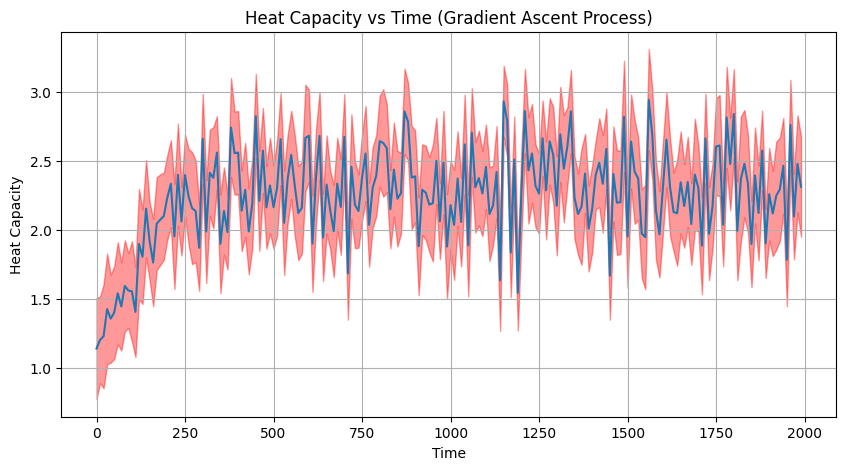

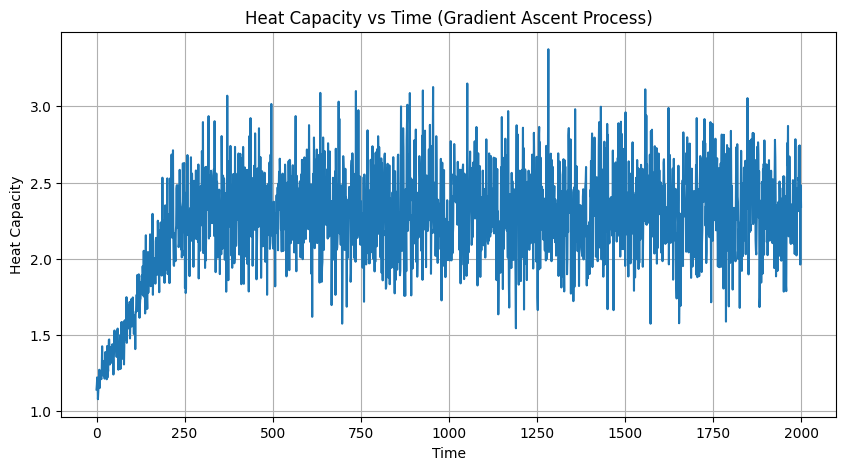

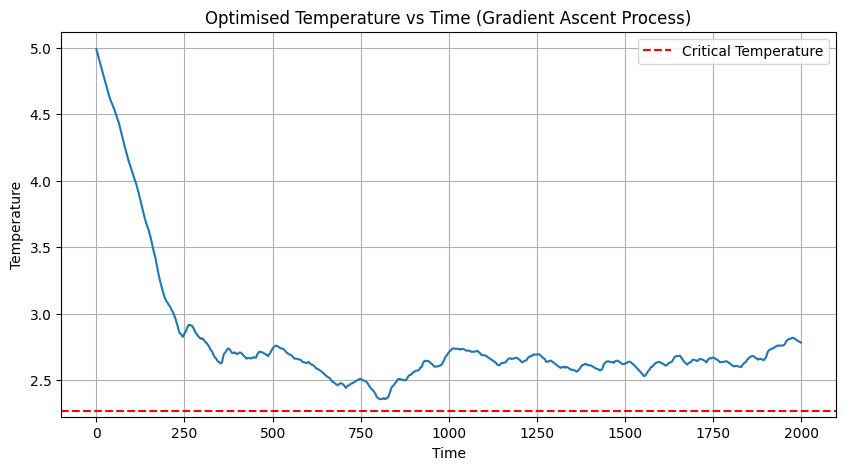

In [110]:
plot_gradient_ascent_results(temperatures_stoch_adam, heat_capacities_stoch_adam, T_c, error_bars_stoch_adam)

run this on remote computer


L = 1:
Optimized temperature for maximum heat capacity is: 4.1552863121032715
Critical temperature is: 2.2691850662231445

Difference between optimized and critical temperature is: 1.886101245880127

L = 2:
Optimized temperature for maximum heat capacity is: 2.6506876945495605
Critical temperature is: 2.2691850662231445

Difference between optimized and critical temperature is: 0.381502628326416

L = 3:
Optimized temperature for maximum heat capacity is: 2.6364407539367676
Critical temperature is: 2.2691850662231445

Difference between optimized and critical temperature is: 0.36725568771362305

L = 4:
Optimized temperature for maximum heat capacity is: 4.1117401123046875
Critical temperature is: 2.2691850662231445

Difference between optimized and critical temperature is: 1.842555046081543

L = 5:
Optimized temperature for maximum heat capacity is: 5.089358329772949
Critical temperature is: 2.2691850662231445

Difference between optimized and critical temperature is: 2.820173263549804

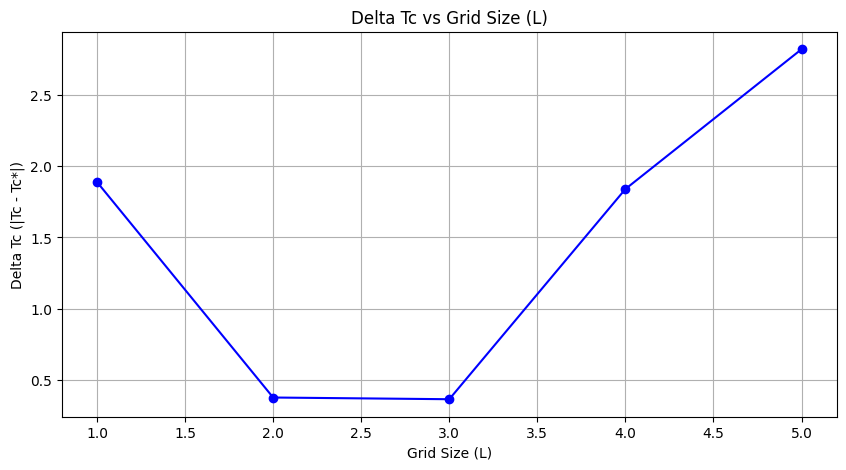

In [111]:
#T_c vs L graph for the stochastic method
L_values = [1, 2, 3, 4, 5] #add up to L = 12
converged_Tc_values, delta_Tc_values = T_c_vs_L(perform_gradient_ascent, gradient_ascent_stochastic_adam, L_values, num_steps, initial_temperature, learning_rate, iterations, step_recording, theta, thermalization, T_c)


#plot delta_Tc vs L
plt.figure(figsize=(10, 5))
plt.plot(L_values, delta_Tc_values, marker='o', linestyle='-', color='b')
plt.xlabel('Grid Size (L)')
plt.ylabel('Delta Tc (|Tc - Tc*|)')
plt.title('Delta Tc vs Grid Size (L)')
plt.grid(True)
plt.show()

In [ ]:
#TODO:

#save only energy, energy squared and heat capacity but not the samples to save up memory
#use int_8 for sampling to save memory
#look into sweeps (only save the relevant ones)
#accumulate gradient AFTER the sweeps because now im saving everything and also AFTER thermalization

#make several markov chains
#make it general for any function 



#TODO after its working:

#change energy function to also take temperature parameter (and never use it)
#take tuple w temperature and theta
#compute it also w.r.t the tuple
#add the additioanal part to (5)


